**Clustering**

In [4]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=7ca9fbb016c1c2f7f100373cfd4ba2a788c882cfcf48065e2283713dafa698dc
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [6]:
from pyspark.sql import SparkSession

In [7]:
spark=SparkSession.builder.appName('unsupervised_learning').getOrCreate()

In [8]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.clustering import KMeans


In [9]:
df=spark.read.csv('music_data.csv',inferSchema=True,
header=True)

In [10]:
df.count()

429023

In [11]:
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- music category: string (nullable = true)



In [12]:
 df.select('music category').distinct().count()

21

In [13]:
df.groupBy('music category').count().orderBy('count',ascending=False).show(100,False)

+-----------------+-----+
|music category   |count|
+-----------------+-----+
|Alternative Music|64227|
|Blues            |54647|
|Classical Music  |43117|
|Country Music    |39891|
|Dance Music      |35779|
|Easy Listening   |34356|
|Electronic Music |30985|
|Rap              |29569|
|Hip Hop          |16895|
|Indie Pop        |16244|
|Motivational     |10118|
|Asian Pop        |8444 |
|Jazz             |7685 |
|Latin Music      |7302 |
|New Age          |7053 |
|Opera            |6188 |
|Hindi Music      |5689 |
|Popular          |4729 |
|Soulful          |2403 |
|Reggae           |1970 |
|Rock             |1732 |
+-----------------+-----+



In [14]:
df.select('user_id').distinct().count()

775

In [15]:
df.groupBy('user_id').count().orderBy('count',ascending=False).show(20,False)

+----------------------------------------------------------------+-----+
|user_id                                                         |count|
+----------------------------------------------------------------+-----+
|628119a73b9725466e6c309f803d30cfc3b11d2a426cdd5f0d62a496e105c914|14257|
|179dd34be075e729f14dadc28a34459226c4f62797af5f186bddbb7428b8fc78|11804|
|2d765ea4ffc6554c95a1c703afcd3470bc118a65c2f0728871f4d0f40628f41b|11001|
|ca60aad85306a7fdd51a469ca6a5d27109dfd5f5781d7da985c70574d2520d23|10479|
|03bfd7e24d3a7ce9e3973f9d42ad89e4c1710b89bec59b2b08712ba73372dcbc|10075|
|7660ca8a4f5df748976aac001d5f0c5b7c8806f5c08197542d26c2eac4b20f85|9932 |
|b6eb8ef9cacc79b6779a7e065c3b0fb5174397ea983d70453bc978b6e46f95e2|7694 |
|e92f348b4a29089c9d7b82095d0bd49422153b60bbde08527015121e44699990|7210 |
|da03e0ef521fecb209f01410eefff11c115fda2d217dde51fd870761b31bb968|7182 |
|04cd1fc5c925a8a702607d6c1a047b8e0cbe170bdaed5270369d321f73254b53|6853 |
|a2374ccb47b0af60aafabeed11b979acf0d72e1afe7f96b671

In [16]:
df.groupBy('user_id').count().orderBy('count',ascending=True).show(20,False)

+----------------------------------------------------------------+-----+
|user_id                                                         |count|
+----------------------------------------------------------------+-----+
|54f2e60bd31a775aca7fb60816c6990a415fe66694098d1ee64cc9e13f831a64|1    |
|a09074b27cd4ab61654c0f4e21bc5e97dc86a611743a1f8b37db3a76df8e306e|1    |
|402c7aac3776a3758ca143819a0653c6cd33c6c35dd831d9ba5aad1dff43a888|1    |
|1e3e7153bf1aa5f43b1d1f27c940087587a50d40d399f4cf31b58546a39b9f26|1    |
|4d5920f000b000d60fdc63043886f47cc056d2835d3a73e50f389a5694b19115|1    |
|ecb27d9bf54e751018cd6c1cc5a0f2d812ff08585271acfc980bdacb742a7a02|1    |
|bdb448f271ec83b324acd32248f1401964cb1f5f716e94eebed508f02e889e14|1    |
|e6e6ceb674b7ca53391ac404558a3f8d222db82c643b8c21070db4f029a50095|1    |
|8691b41f5ae65644c8aca0ec9d738eb3b5537b106f0fdcb3f652cc77b7ab7dd6|1    |
|8aced64c96741dbeab4659f102f34c157189b3f7a63807d87bad5d8c663005cb|1    |
|55efc631da61b192de874d5e2b05ea1e04ec08bd2e3009ebcd

1.-Reshaping Dataframe for Clustering

In [17]:
feature_df=df.stat.crosstab("user_id", "music category")

In [18]:
feature_df.printSchema()

root
 |-- user_id_music category: string (nullable = true)
 |-- Alternative Music: long (nullable = false)
 |-- Asian Pop: long (nullable = false)
 |-- Blues: long (nullable = false)
 |-- Classical Music: long (nullable = false)
 |-- Country Music: long (nullable = false)
 |-- Dance Music: long (nullable = false)
 |-- Easy Listening: long (nullable = false)
 |-- Electronic Music: long (nullable = false)
 |-- Hindi Music: long (nullable = false)
 |-- Hip Hop: long (nullable = false)
 |-- Indie Pop: long (nullable = false)
 |-- Jazz: long (nullable = false)
 |-- Latin Music: long (nullable = false)
 |-- Motivational: long (nullable = false)
 |-- New Age: long (nullable = false)
 |-- Opera: long (nullable = false)
 |-- Popular: long (nullable = false)
 |-- Rap: long (nullable = false)
 |-- Reggae: long (nullable = false)
 |-- Rock: long (nullable = false)
 |-- Soulful: long (nullable = false)



In [19]:
feature_df.show(3,False)

+----------------------------------------------------------------+-----------------+---------+-----+---------------+-------------+-----------+--------------+----------------+-----------+-------+---------+----+-----------+------------+-------+-----+-------+---+------+----+-------+
|user_id_music category                                          |Alternative Music|Asian Pop|Blues|Classical Music|Country Music|Dance Music|Easy Listening|Electronic Music|Hindi Music|Hip Hop|Indie Pop|Jazz|Latin Music|Motivational|New Age|Opera|Popular|Rap|Reggae|Rock|Soulful|
+----------------------------------------------------------------+-----------------+---------+-----+---------------+-------------+-----------+--------------+----------------+-----------+-------+---------+----+-----------+------------+-------+-----+-------+---+------+----+-------+
|f0aead442015795909760d6557c0ac7228a2b5beeedeb5daf2de29040c528f22|58               |0        |4    |2              |4            |7          |29            |

In [20]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [21]:
print(feature_df.columns)

['user_id_music category', 'Alternative Music', 'Asian Pop', 'Blues', 'Classical Music', 'Country Music', 'Dance Music', 'Easy Listening', 'Electronic Music', 'Hindi Music', 'Hip Hop', 'Indie Pop', 'Jazz', 'Latin Music', 'Motivational', 'New Age', 'Opera', 'Popular', 'Rap', 'Reggae', 'Rock', 'Soulful']


In [22]:
feat_cols=[col for col in feature_df.columns if col !='user_id_music category']

In [23]:
print(feat_cols)

['Alternative Music', 'Asian Pop', 'Blues', 'Classical Music', 'Country Music', 'Dance Music', 'Easy Listening', 'Electronic Music', 'Hindi Music', 'Hip Hop', 'Indie Pop', 'Jazz', 'Latin Music', 'Motivational', 'New Age', 'Opera', 'Popular', 'Rap', 'Reggae', 'Rock', 'Soulful']


In [24]:
vec_assembler = VectorAssembler(inputCols = feat_cols, outputCol='features')

In [25]:
final_data = vec_assembler.transform(feature_df)

In [26]:
final_data.printSchema()

root
 |-- user_id_music category: string (nullable = true)
 |-- Alternative Music: long (nullable = false)
 |-- Asian Pop: long (nullable = false)
 |-- Blues: long (nullable = false)
 |-- Classical Music: long (nullable = false)
 |-- Country Music: long (nullable = false)
 |-- Dance Music: long (nullable = false)
 |-- Easy Listening: long (nullable = false)
 |-- Electronic Music: long (nullable = false)
 |-- Hindi Music: long (nullable = false)
 |-- Hip Hop: long (nullable = false)
 |-- Indie Pop: long (nullable = false)
 |-- Jazz: long (nullable = false)
 |-- Latin Music: long (nullable = false)
 |-- Motivational: long (nullable = false)
 |-- New Age: long (nullable = false)
 |-- Opera: long (nullable = false)
 |-- Popular: long (nullable = false)
 |-- Rap: long (nullable = false)
 |-- Reggae: long (nullable = false)
 |-- Rock: long (nullable = false)
 |-- Soulful: long (nullable = false)
 |-- features: vector (nullable = true)



In [27]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features",outputCol="scaledFeatures", withStd=True, withMean=False)

In [28]:
scalerModel = scaler.fit(final_data)

In [31]:
cluster_final_data = scalerModel.transform(final_data)

In [32]:
cluster_final_data.columns

['user_id_music category',
 'Alternative Music',
 'Asian Pop',
 'Blues',
 'Classical Music',
 'Country Music',
 'Dance Music',
 'Easy Listening',
 'Electronic Music',
 'Hindi Music',
 'Hip Hop',
 'Indie Pop',
 'Jazz',
 'Latin Music',
 'Motivational',
 'New Age',
 'Opera',
 'Popular',
 'Rap',
 'Reggae',
 'Rock',
 'Soulful',
 'features',
 'scaledFeatures']

2.-Building clusters with K-means

In [35]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [36]:
silhouette_score=[]

evaluator = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='scaledFeatures',
                                metricName='silhouette',
                                distanceMeasure='squaredEuclidean')

In [39]:
errors=[]
for k in range(2,10):
    kmeans = KMeans(featuresCol='scaledFeatures',k=k)
    model=kmeans.fit(cluster_final_data)
    predictions=model.transform(cluster_final_data)
    score=evaluator.evaluate(predictions)
    silhouette_score.append(score)
    print('Silhouette Score for k =',k,'is',score)

Silhouette Score for k = 2 is 0.9393723378253583
Silhouette Score for k = 3 is 0.8895587007962985
Silhouette Score for k = 4 is 0.9227932423404981
Silhouette Score for k = 5 is 0.7754612917349782
Silhouette Score for k = 6 is 0.898163075052885
Silhouette Score for k = 7 is 0.8669682731077585
Silhouette Score for k = 8 is 0.8919484622326637
Silhouette Score for k = 9 is 0.9023812842121226


In [40]:
import matplotlib.pyplot as plt

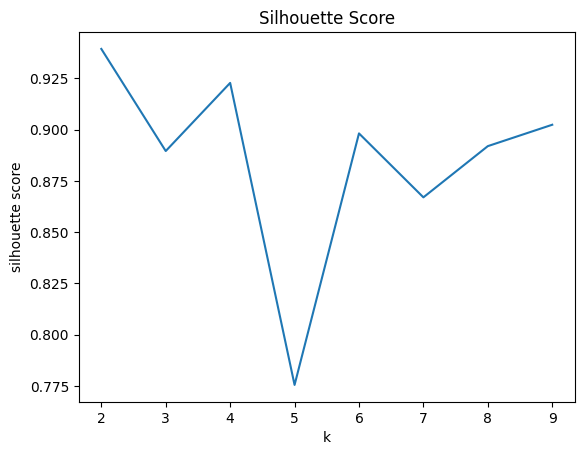

In [42]:
plt.plot(range(2,10),silhouette_score)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.show()

In [43]:
kmeans6 = KMeans(featuresCol='scaledFeatures',k=6)

In [44]:
model_k6 = kmeans6.fit(cluster_final_data)

In [45]:
model_k6.transform(cluster_final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|    1|
|         3|    4|
|         5|    3|
|         4|   15|
|         2|    1|
|         0|  751|
+----------+-----+



In [46]:
model_k6.transform(cluster_final_data).show()

+----------------------+-----------------+---------+-----+---------------+-------------+-----------+--------------+----------------+-----------+-------+---------+----+-----------+------------+-------+-----+-------+---+------+----+-------+--------------------+--------------------+----------+
|user_id_music category|Alternative Music|Asian Pop|Blues|Classical Music|Country Music|Dance Music|Easy Listening|Electronic Music|Hindi Music|Hip Hop|Indie Pop|Jazz|Latin Music|Motivational|New Age|Opera|Popular|Rap|Reggae|Rock|Soulful|            features|      scaledFeatures|prediction|
+----------------------+-----------------+---------+-----+---------------+-------------+-----------+--------------+----------------+-----------+-------+---------+----+-----------+------------+-------+-----+-------+---+------+----+-------+--------------------+--------------------+----------+
|  f0aead44201579590...|               58|        0|    4|              2|            4|          7|            29|         

In [47]:
cluser_prediction=model_k6.transform(cluster_final_data)

In [48]:
cluser_prediction.printSchema()

root
 |-- user_id_music category: string (nullable = true)
 |-- Alternative Music: long (nullable = false)
 |-- Asian Pop: long (nullable = false)
 |-- Blues: long (nullable = false)
 |-- Classical Music: long (nullable = false)
 |-- Country Music: long (nullable = false)
 |-- Dance Music: long (nullable = false)
 |-- Easy Listening: long (nullable = false)
 |-- Electronic Music: long (nullable = false)
 |-- Hindi Music: long (nullable = false)
 |-- Hip Hop: long (nullable = false)
 |-- Indie Pop: long (nullable = false)
 |-- Jazz: long (nullable = false)
 |-- Latin Music: long (nullable = false)
 |-- Motivational: long (nullable = false)
 |-- New Age: long (nullable = false)
 |-- Opera: long (nullable = false)
 |-- Popular: long (nullable = false)
 |-- Rap: long (nullable = false)
 |-- Reggae: long (nullable = false)
 |-- Rock: long (nullable = false)
 |-- Soulful: long (nullable = false)
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)
 |-- predic

In [49]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

In [50]:
pca = PCA(k=3, inputCol="scaledFeatures", outputCol="pca_features")

In [51]:
pca_model = pca.fit(cluser_prediction)

In [52]:
result = pca_model.transform(cluser_prediction).select('user_id_music category',"pca_features",'prediction')

In [53]:
result.show(truncate=False)

+----------------------------------------------------------------+---------------------------------------------------------------------+----------+
|user_id_music category                                          |pca_features                                                         |prediction|
+----------------------------------------------------------------+---------------------------------------------------------------------+----------+
|f0aead442015795909760d6557c0ac7228a2b5beeedeb5daf2de29040c528f22|[-0.42927525007307854,0.3716962144659412,-0.0767274733349946]        |0         |
|113e8bf3d09529d0cc246227019e26d4463a72820c298864be6c651d29dcf6e4|[-4.373631064688691,1.5691189605286477,-0.08275543449064761]         |0         |
|d20e466a7b1817e9efd791d9b80c87c8eeffe50f091ab7ad8206e7416f3defed|[-0.6698144701036586,0.22262413940175177,-0.1410813363716798]        |0         |
|9b126a6f98cb8d162f56c4c6b19f0a56656bcd9a5227a68406e6065f0a3b81e0|[-1.0987585365868788,0.683428597907463,-0.8211

In [55]:
clusters = result.toPandas().set_index('user_id_music category')

In [56]:
clusters.head(10)

,pca_features,prediction
user_id_music category,,
f0aead442015795909760d6557c0ac7228a2b5beeedeb5daf2de29040c528f22,"[-0.42927525007307854, 0.3716962144659412, -0....",0
113e8bf3d09529d0cc246227019e26d4463a72820c298864be6c651d29dcf6e4,"[-4.373631064688691, 1.5691189605286477, -0.08...",0
d20e466a7b1817e9efd791d9b80c87c8eeffe50f091ab7ad8206e7416f3defed,"[-0.6698144701036586, 0.22262413940175177, -0....",0
9b126a6f98cb8d162f56c4c6b19f0a56656bcd9a5227a68406e6065f0a3b81e0,"[-1.0987585365868788, 0.683428597907463, -0.82...",0
87b0bba0e0cd5de24fa81ad84ada517eaef2390f0d189cd602dc5a6ba8a8f454,"[-0.14748441025903347, 0.00045039230544984335,...",0
11823c5255dc7ec28e8a60ec7c079136e914a155c631474b6a6a2ac217335e34,"[-1.8305620048734774, 1.2863353697184692, -0.0...",0
e7fbd81ffdc83686931bb800157063e78de9dabee0d1eb6b3885fb9658ab0c72,"[-0.7824083382846667, 0.42048110631362645, -0....",0
c35319ee2098f691c5c90e35bb7a68f5b679d3eab1f6b955f27bad71ee907ab8,"[-3.6798756375717616, 3.7888362620194975, -0.9...",0
586c34c75e5d16597cf974a34e2cba6720521a238971e4abf988b5c711adbfae,"[-0.9768104631666616, 1.343704850308886, 0.065...",0


In [57]:
clusters[['x','y','z']]=pd.DataFrame(clusters.pca_features.values.tolist(), index= clusters.index)

In [58]:
del clusters['pca_features']

In [59]:
clusters.head(10)

,prediction,x,y,z
user_id_music category,,,,
f0aead442015795909760d6557c0ac7228a2b5beeedeb5daf2de29040c528f22,0,-0.429275,0.371696,-0.076727
113e8bf3d09529d0cc246227019e26d4463a72820c298864be6c651d29dcf6e4,0,-4.373631,1.569119,-0.082755
d20e466a7b1817e9efd791d9b80c87c8eeffe50f091ab7ad8206e7416f3defed,0,-0.669814,0.222624,-0.141081
9b126a6f98cb8d162f56c4c6b19f0a56656bcd9a5227a68406e6065f0a3b81e0,0,-1.098759,0.683429,-0.821131
87b0bba0e0cd5de24fa81ad84ada517eaef2390f0d189cd602dc5a6ba8a8f454,0,-0.147484,0.000450,-0.057861
11823c5255dc7ec28e8a60ec7c079136e914a155c631474b6a6a2ac217335e34,0,-1.830562,1.286335,-0.078945
e7fbd81ffdc83686931bb800157063e78de9dabee0d1eb6b3885fb9658ab0c72,0,-0.782408,0.420481,-0.134903
c35319ee2098f691c5c90e35bb7a68f5b679d3eab1f6b955f27bad71ee907ab8,0,-3.679876,3.788836,-0.912343
586c34c75e5d16597cf974a34e2cba6720521a238971e4abf988b5c711adbfae,0,-0.976810,1.343705,0.065893


In [60]:
from mpl_toolkits.mplot3d import Axes3D

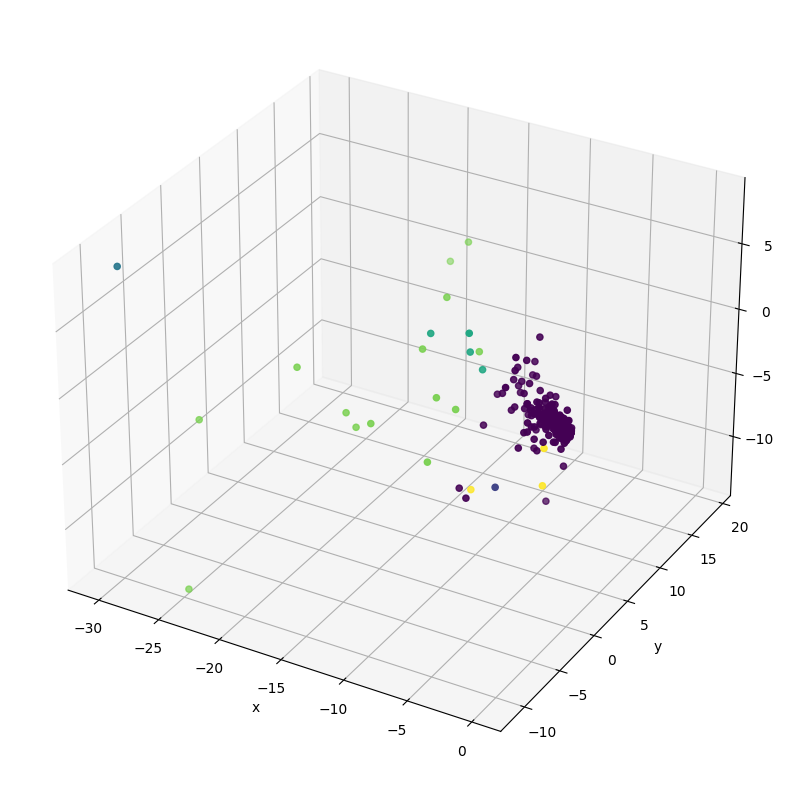

In [62]:
cluster_vis = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
cluster_vis.scatter(clusters.x, clusters.y, clusters.z, c=clusters.prediction)
cluster_vis.set_xlabel('x')
cluster_vis.set_ylabel('y')
cluster_vis.set_zlabel('z')
plt.show()